In [2]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import tqdm

from typing import*

from collections import*
# from scipy import*
from sklearn.metrics import*

from numpy import *

# bltin_sum = np.sum

In [3]:
# Functions

# def add(a, b): return a + b

Vector = List[float]


def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

#     return np.sum(v_i * w_i for v_i, w_i in zip(v, w))
#     gen = 
    return np.sum(np.fromiter((v_i * w_i for v_i, w_i in zip(v, w)),float))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = data.shape[0]
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = data.shape[0]
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                
def step_function(x: float) -> float:
    return 1.0 if x >= 0 else 0.0

def sigmoid(t: float) -> float: 
    return 1 / (1 + math.exp(-t))

# Gradient Descent - step
def gradient_step(v: Vector, gradient: Vector, step_size: float):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2 * v_i for v_i in v]

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

In [4]:
def difference_quotient(f: Callable[[float], float],
                        x: float,
                        h: float) -> float:
    return (f(x + h) - f(x)) / h

In [5]:
def square(x: float) -> float:
    return x * x

In [6]:
def derivative(x: float) -> float:
    return 2 * x

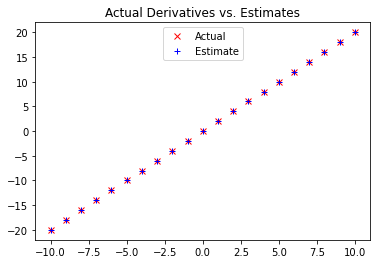

In [7]:
xs = range(-10, 11)
actuals = [derivative(x) for x in xs]
estimates = [difference_quotient(square, x, h=0.001) for x in xs]
 
# plot to show they're basically the same
# import matplotlib.pyplot as plt
plt.title("Actual Derivatives vs. Estimates")
plt.plot(xs, actuals, 'rx', label='Actual')       # red  x
plt.plot(xs, estimates, 'b+', label='Estimate')   # blue +
plt.legend(loc=9)
plt.show()

In [8]:
def partial_difference_quotient(f: Callable[[Vector],float], v, i, h: float):
    """Returns the i-th partial difference quotient of f at v"""
    w = [v_j + (h if j == i else 0)    # add h to just the ith element of  v
         for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

In [9]:
def estimate_gradient(f: Callable[[Vector], float],
                      v: Vector,
                      h: float = 0.0001):
    return [partial_difference_quotient(f, v, i, h)
            for i in range(len(v))]

In [10]:

def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2 * v_i for v_i in v]

# pick a random starting point
v = [random.uniform(-10, 10) for i in range(3)]

for epoch in range(1000):
    grad = sum_of_squares_gradient(v)    # compute the gradient at v
    v = gradient_step(v, grad, -0.01)    # take a negative gradient step
#     print(epoch, v)

distance(v, [0, 0, 0]) 

7.965300468877181e-09

In [11]:
# x ranges from -50 to 49, y is always 20 * x + 5
inputs = [(x, 20 * x + 5) for x in range(-50, 50)]

In [12]:
def linear_gradient(x: float, y: float, theta: Vector) -> Vector:
    slope, intercept = theta 
    predicted = slope * x + intercept    # The prediction of the model.
    error = (predicted - y)              # error is (predicted - actual).
    squared_error = error ** 2           # We'll minimize squared error 
    grad = [2 * error * x, 2 * error]    # using its gradient.
    return grad

In [13]:
 
# Start with random values for slope and intercept
theta = [random.uniform(-1, 1), random.uniform(-1, 1)] 

learning_rate = 0.001

with tqdm.trange(2500) as t:
    for epoch in t: 
        # Compute the mean of the gradients
        grad = vector_mean([linear_gradient(x, y, theta) for x, y in inputs])
        # Take a step in that direction
        theta = gradient_step(theta, grad, -learning_rate)
    #     print(epoch, theta)

slope, intercept = theta


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 2512.87it/s]


In [14]:
T = TypeVar('T')  # this allows us to type "generic" functions

def minibatches(dataset: List[T],
                batch_size: int,
                shuffle: bool = True) -> Iterator[List[T]]:
    """Generates `batch_size`-sized minibatches from the dataset"""
    # start indexes 0, batch_size, 2 * batch_size, ...
    batch_starts = [start for start in range(0, len(dataset), batch_size)]

    if shuffle: random.shuffle(batch_starts)  # shuffle the batches
 
    for start in batch_starts:
        end = start + batch_size
        yield dataset[start:end]

In [15]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(1000):
    for batch in minibatches(inputs, batch_size=20):
        grad = vector_mean([linear_gradient(x, y, theta) for x, y in batch])
        theta = gradient_step(theta, grad, -learning_rate)
#     print(epoch, theta)

slope, intercept = theta
intercept
slope

19.999999963709264

In [16]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(100):
    for x, y in inputs:
        grad = linear_gradient(x, y, theta)
        theta = gradient_step(theta, grad, -learning_rate)
#     print(epoch, theta)

slope,intercept = theta
print(slope)
print(intercept)


20.001527534785854
4.923970720282147


In [17]:
# theta = [random.uniform(-1, 1), random.uniform(-1, 1),random.uniform(-1, 1)]
# # pick a random starting point
# v = [random.uniform(-1, 1) for i in range(3)]
# # print(v)

# for epoch in range(5000):
#     grad = sum_of_squares_gradient(theta)    # compute the gradient at v
#     theta = gradient_step(theta, grad, -0.001)    # take a negative gradient step
# #     print(epoch, v)
# print(v)

# # for epoch in range(100):
# #     for i in range(len(inputs)):
# #         grad = linear_gradient(inputs[i][0], inputs[i][1], theta)
# #         theta = gradient_step(theta, grad, -learning_rate)
# # #     print(epoch, theta)

# # slope,intercept = theta
# # print(slope)
# # print(intercept)
# # inputs[0][2]
# # print(grad)
# # print(theta)

In [18]:
# theta = [random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1)]
# learning_rate = 0.001

# n = 1000
# x = np.random.uniform(-2.0, 2.0, n)
# y = 2.0 * x * x + 1.23456 * x + 4.5678 + np.random.normal(0.0, 1.0, n)

# for epoch in range(100):
#     for i in range(len(inputs)):
#         m, slope, intercept = theta 
#         predicted = m*np.square(inputs[i][0]) + slope * inputs[i][0] + intercept    # The prediction of the model.
#         error = (inputs[i][1] - predicted)              # error is (predicted - actual).
#         squared_error = error ** 2           # We'll minimize squared error 
#         grad = [-2 * error * inputs[i][0]**2,-2 * error * inputs[i][0], -2 * error]    # using its gradient.
        
# #         theta = gradient_step(theta, grad, -learning_rate)
        
# # slope,intercept = theta
# # print(slope)
# # print(intercept)
# grad

In [19]:
x_in = []
y_in = []
for i in range(len(inputs)):
    x_in.append([1] + [inputs[i][0]])
#     x_in.append([1] + [inputs[i][0]])
    y_in.append(inputs[i][1])
x_in[0]

[1, -50]

In [20]:
learning_rate = 0.0001
beta = least_squares_fit(x_in, y_in, learning_rate, 5000, 25)
# assert 30.50 < beta[0] < 30.70  # constant

least squares fit: 100%|██████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 757.49it/s]


In [21]:
beta

array([ 4.93726479, 20.00027134])